In [1]:
import torch
import scipy
import math
import numpy as np
import json
from config import cfg
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from models import build_model
from data import build_dataloaders
from edl.model import uncertainty

In [2]:
with open(f'{cfg.PATHS.OUTPUT_DIR}/results.json', 'r') as file: results = json.load(file)

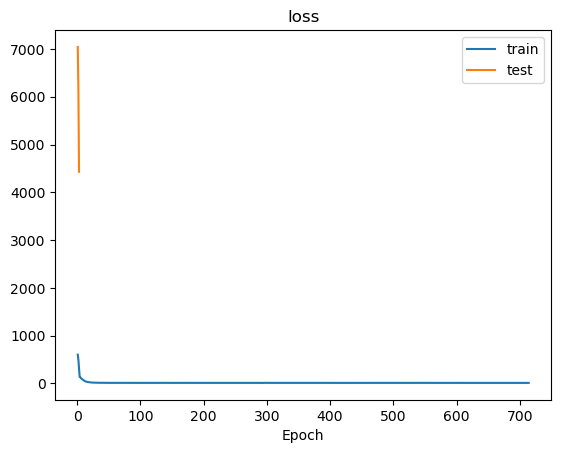

KeyError: 'train_loss_nll_epoch_1'

In [3]:
epochs = range(1, cfg.TRAINER.MAX_EPOCHS+1)
for metric in ['loss', 'loss_nll', 'loss_reg', 'mse']:
    for mode in ['train', 'test']:
        losses = [results[f'{mode}_{metric}_epoch_{epoch}'] for epoch in epochs]
        plt.plot(epochs, losses, label=mode)
    plt.legend()
    plt.xlabel('Epoch')
    plt.title(metric)
    plt.show()

In [10]:
model = build_model().to(cfg.DEVICE)
model.load_state_dict(torch.load(f'{cfg.PATHS.OUTPUT_DIR}/final.pt'))
model.eval()
dataloaders = build_dataloaders()

In [11]:
with torch.no_grad():
    xs, gammas, ys = [], [], []
    AUs, EUs = [], []
    for x, y in tqdm(dataloaders['test']):
        x, y = x.to(cfg.DEVICE), y.to(cfg.DEVICE)
        # with torch.cuda.amp.autocast():
        out = model(x)
        gamma = out[2]
        AU, EU = uncertainty(out)
        
        xs.append(x)
        gammas.append(gamma)
        ys.append(y)
        AUs.append(AU)
        EUs.append(EU)
    xs = torch.cat(xs).detach().cpu().numpy()[:, 0]
    gammas = torch.cat(gammas).detach().cpu().numpy()[:, 0]
    ys = torch.cat(ys).detach().cpu().numpy()[:, 0]
    AUs = torch.cat(AUs).detach().cpu().numpy()[:, 0]
    EUs = torch.cat(EUs).detach().cpu().numpy()[:, 0]

100%|██████████| 8/8 [00:00<00:00, 1087.49it/s]


In [12]:
for xx in out: print(xx.mean())

tensor(25.3192, device='cuda:0')
tensor(2.9697e-18, device='cuda:0')
tensor(111.6226, device='cuda:0')
tensor(32.7762, device='cuda:0')


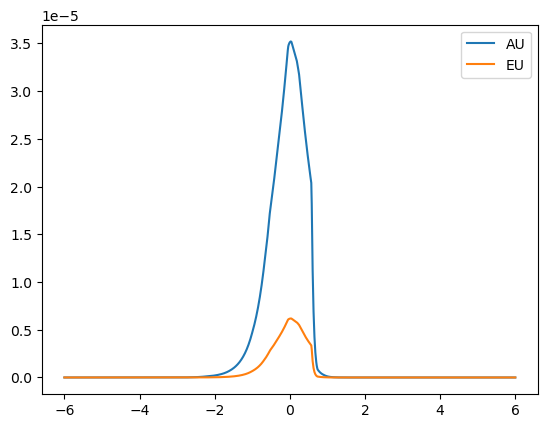

In [16]:
plt.plot(xs, AUs, label='AU')
plt.plot(xs, EUs, label='EU')
plt.legend()
plt.show()

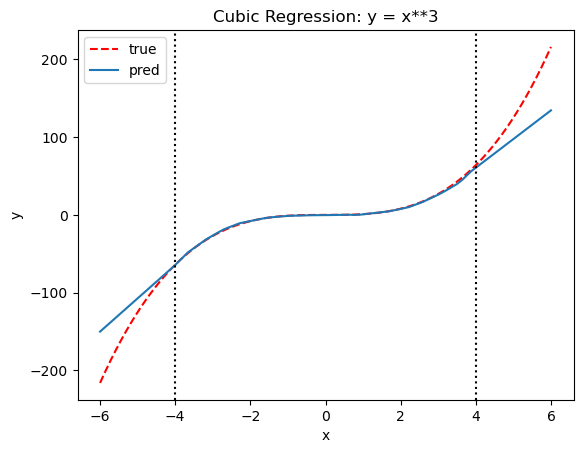

In [15]:
plt.plot(xs, ys, label='true', linestyle='dashed', color='red')
plt.plot(xs, gammas, label='pred')
plt.axvline(-4, linestyle='dotted', color='black')
plt.axvline(4, linestyle='dotted', color='black')
plt.xlabel('x'); plt.ylabel('y'); plt.title('Cubic Regression: y = x**3')
plt.legend()
plt.show()